In [1]:
import pandas as pd
tempdf = pd.read_parquet('data/Transactions_Cleaned.parquet')

print("DataFrame loaded successfully!")
print(f"Shape of loaded DataFrame: {tempdf.shape}")
print("\nData Types:")
print(tempdf.info())

DataFrame loaded successfully!
Shape of loaded DataFrame: (984247, 11)

Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984247 entries, 0 to 984246
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            984247 non-null  object        
 1   CustomerID               984247 non-null  object        
 2   CustomerDOB              984247 non-null  datetime64[ns]
 3   CustGender               984247 non-null  object        
 4   CustLocation             984247 non-null  object        
 5   CustAccountBalance       984247 non-null  float64       
 6   TransactionDate          984247 non-null  datetime64[ns]
 7   TransactionTime          984247 non-null  object        
 8   TransactionAmount (INR)  984247 non-null  float64       
 9   Age                      984247 non-null  int64         
 10  age_group                984247 non-null  category      

## 1. Feature Engineering

## 1.1 Customer RFM Segmentation
    Due to the data being grouped at the transactional level, we will need to extract customer-level aggregates
    to produce customer-level insights like churn risk and activity level.

In [4]:
# Aggregating Transactions by Customer
customer_agg = tempdf.groupby('CustomerID').agg({
    'TransactionAmount (INR)': ['count', 'sum', 'mean', 'max'],
    'CustAccountBalance': 'mean',
    'TransactionDate': ['min', 'max'],
    'CustLocation': 'first',
    'CustGender': 'first'
})
customer_agg.columns = [
    'txn_count', 'total_spent', 'avg_spent', 'max_spent',
    'avg_balance',
    'first_txn_date', 'last_txn_date',
    'location', 'gender'
]
customer_agg.reset_index(inplace=True)

In [5]:
from datetime import datetime

customer_agg['first_txn_date'] = pd.to_datetime(customer_agg['first_txn_date'])
customer_agg['last_txn_date'] = pd.to_datetime(customer_agg['last_txn_date'])

# Recency: Days since last transaction
reference_date = tempdf['TransactionDate'].max()
customer_agg['recency_days'] = (reference_date - customer_agg['last_txn_date']).dt.days

# Tenure: How long the customer has been transacting
customer_agg['tenure_days'] = (customer_agg['last_txn_date'] - customer_agg['first_txn_date']).dt.days

# Average transactions per month
customer_agg['txn_per_day'] = customer_agg['txn_count'] / customer_agg['tenure_days'].replace(0, 1)

# Average transaction as % of balance
customer_agg['avg_spent_pct_balance'] = customer_agg['avg_spent'] / customer_agg['avg_balance']

customer_agg.head(5)

,CustomerID,txn_count,total_spent,avg_spent,max_spent,avg_balance,first_txn_date,last_txn_date,location,gender,recency_days,tenure_days,txn_per_day,avg_spent_pct_balance
0,C1010011,2,5106.0,2553.0,4750.0,76340.635,2016-08-09,2016-09-26,NOIDA,F,25,48,0.041667,0.033442
1,C1010012,1,1499.0,1499.0,1499.0,24204.490,2016-08-14,2016-08-14,MUMBAI,M,68,0,1.000000,0.061931
2,C1010014,2,1455.0,727.5,1205.0,100112.950,2016-08-01,2016-08-07,MUMBAI,F,75,6,0.333333,0.007267
3,C1010018,1,30.0,30.0,30.0,496.180,2016-09-15,2016-09-15,CHAMPARAN,F,36,0,1.000000,0.060462
4,C1010024,1,5000.0,5000.0,5000.0,87058.650,2016-08-18,2016-08-18,KOLKATA,M,64,0,1.000000,0.057433


In [6]:
rfm = customer_agg[['CustomerID', 'recency_days', 'txn_count', 'total_spent']].copy()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Quantile-based scoring (1–5)
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])  #lower the recency, the better
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combining RFM into a score
rfm['RFM Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

rfm['RFM Score'].value_counts().head(10).sort_index()

RFM Score
311     8408
321     8533
331     8388
354     8933
355    11325
454    12195
455    15899
553     9623
554    14213
555    19050
Name: count, dtype: int64

##  Objective 
    To have an exhaustive categorization of all customers, so a simple if-else statement may not handle edge cases appropriately and may have logical gaps. Instead, we will start from score combinations and make a pivot table of all RFM Score counts accordingly assigning segment names to each unique combination.

In [7]:
import pandas as pd

rfm['RFM Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)


#Pivot Table Insight
print("Analyzing RFM Score Distribution\n")
rfm_score_counts = rfm['RFM Score'].value_counts().sort_index()

with pd.option_context('display.max_rows', 125):
    print(rfm_score_counts)

print("\nBUILDING SEGMENTS")

segment_map = {
    #Regex Pattern
    r'[4-5][4-5][4-5]': 'Champions',
    r'[4-5][1-2][1-5]': 'New Customers',
    r'[4-5][3-5][1-3]': 'Potential Loyalists',
    r'3[3-5][3-5]':     'Loyal Customers',
    r'1[4-5][4-5]':     "At Risk (High-value)",
    r'3[1-2][1-3]':     'At Risk',
    r'[1-2][1-2][1-5]': 'At Risk (Inactive)',
    r'[1-2][3-5][3-5]': 'Need Attention',
}

rfm['Segment'] = rfm['RFM Score'].replace(segment_map, regex=True)

# Safety check to handle edge case of scores not matching any one segment
rfm['Segment'] = rfm['Segment'].apply(lambda x: 'Uncategorized' if x.isdigit() else x)

print("\nFinal Segment Counts:\n")
print(rfm['Segment'].value_counts())

print("\nSample of Final DF\n")
print(rfm[['CustomerID', 'RFM Score', 'Segment']].head(10))

Analyzing RFM Score Distribution

RFM Score
111     7944
112     7826
113     7297
114     6540
115     5906
121     7878
122     7700
123     7281
124     6533
125     5965
131     8032
132     7928
133     7335
134     6666
135     5950
141     8006
142     7817
143     7262
144     6661
145     5949
151     2072
152     2345
153     2720
154     3132
155     3442
211     7829
212     7521
213     7272
214     6867
215     5972
221     7933
222     7542
223     7347
224     6817
225     6028
231     7805
232     7501
233     7125
234     6763
235     6055
241     7875
242     7519
243     7216
244     6917
245     6055
251     2369
252     3163
253     4785
254     6375
255     7914
311     8408
312     7576
313     6554
314     5859
315     5151
321     8533
322     7436
323     6546
324     5830
325     5059
331     8388
332     7352
333     6551
334     5654
335     5089
341     8340
342     7548
343     6335
344     5843
345     5070
351     2823
352     4255
353     6478
354    

In [8]:
uncategorized_customers = rfm[rfm['Segment'] == 'Uncategorized']

print("Uncategorized RFM Scores:\n")
print(uncategorized_customers['RFM Score'].value_counts())

Uncategorized RFM Scores:

RFM Score
331    8388
341    8340
131    8032
141    8006
132    7928
241    7875
142    7817
231    7805
342    7548
242    7519
232    7501
332    7352
434    5923
314    5859
324    5830
534    5454
435    5421
315    5151
325    5059
535    5003
352    4255
252    3163
351    2823
251    2369
152    2345
151    2072
Name: count, dtype: int64


In [9]:
# Rebuilding map from analysis of uncategorized scores.
# Ordered by most valuable to least valuable.

segment_map_final = {
    # High-Value Tiers
    r'[4-5][4-5][4-5]': 'Champions',                     # Best
    r'[3-4][4-5][4-5]': 'Elite',                         # Loyal and high-spending, but less recent
    r'[4-5]3[3-5]':     'Potential High-Value',          # Recent, high-spending, but moderately frequent (434, 535)

    # Mid-Value Tiers
    r'[3-5][3-5][1-3]': 'Active, Low-Spenders',          # Active and frequent, but spend little (331, 341)
    r'[4-5][1-2][1-5]': 'New Customers',                 # Very recent, but low frequency
    r'3[1-3][1-5]':     'Promising',                     # Moderately recent, low-to-average frequency

    # At-Risk Tiers
    r'[1-2][3-5][3-5]': "Critical",                      # Were high-value, but now inactive
    r'[2-3][1-3][1-5]': 'Needs Attention',               # Recency and frequency on decline
    
    # Segment for Low Recency
    r'[1-2][1-5][1-5]': 'At Risk/ Lost',                 # For all remaining customers with low recency (r=1 or 2)
}

rfm['Segment_Final'] = rfm['RFM Score'].replace(segment_map_final, regex=True)

# Safety check for remaining 'Uncategorized' customers
rfm['Segment_Final'] = rfm['Segment_Final'].apply(lambda x: 'Uncategorized' if x.isdigit() else x)

print("Final Segment Counts\n")
print(rfm['Segment_Final'].value_counts())

print("\nRemaining Uncategorized Count")
print(rfm[rfm['Segment_Final'] == 'Uncategorized']['RFM Score'].value_counts())

Final Segment Counts

Segment_Final
Active, Low-Spenders    162336
At Risk/ Lost           127996
New Customers           126398
Critical                108322
Needs Attention          86434
Champions                83305
Promising                77695
Potential High-Value     34713
Elite                    31171
Name: count, dtype: int64

Remaining Uncategorized Count
Series([], Name: count, dtype: int64)


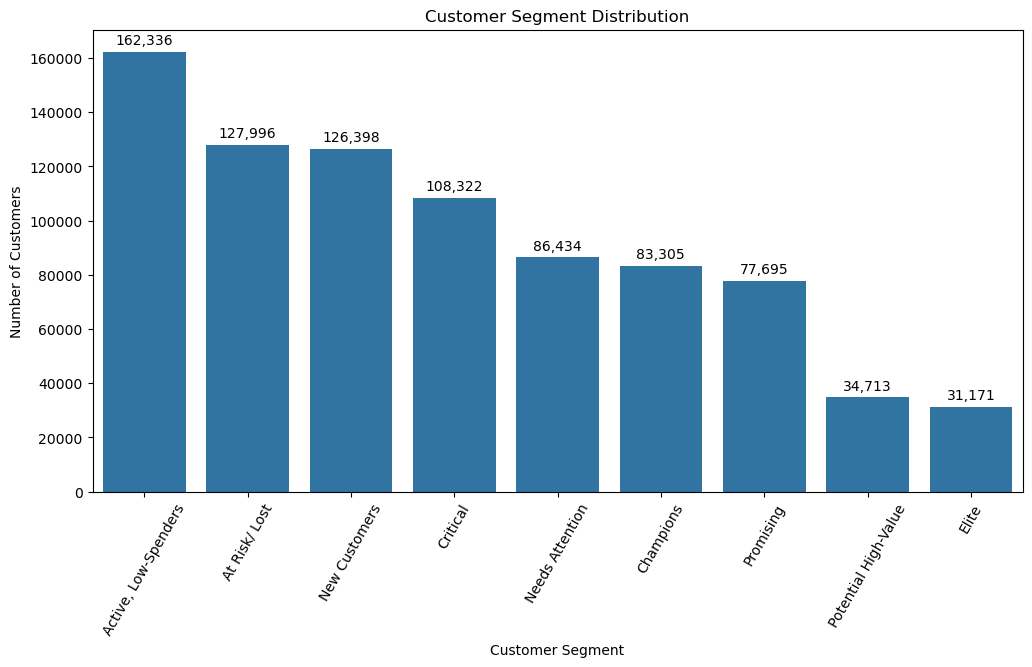

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
ax = sns.countplot(data=rfm, x='Segment_Final', order=rfm['Segment_Final'].value_counts().index)

segment_counts = rfm['Segment_Final'].value_counts()
for i, count in enumerate(segment_counts):
    ax.text(i, count + 0.01 * max(segment_counts), f'{count:,}', 
            ha='center', va='bottom', fontsize=10)

plt.title("Customer Segment Distribution")
plt.xticks(rotation=60)
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.show()

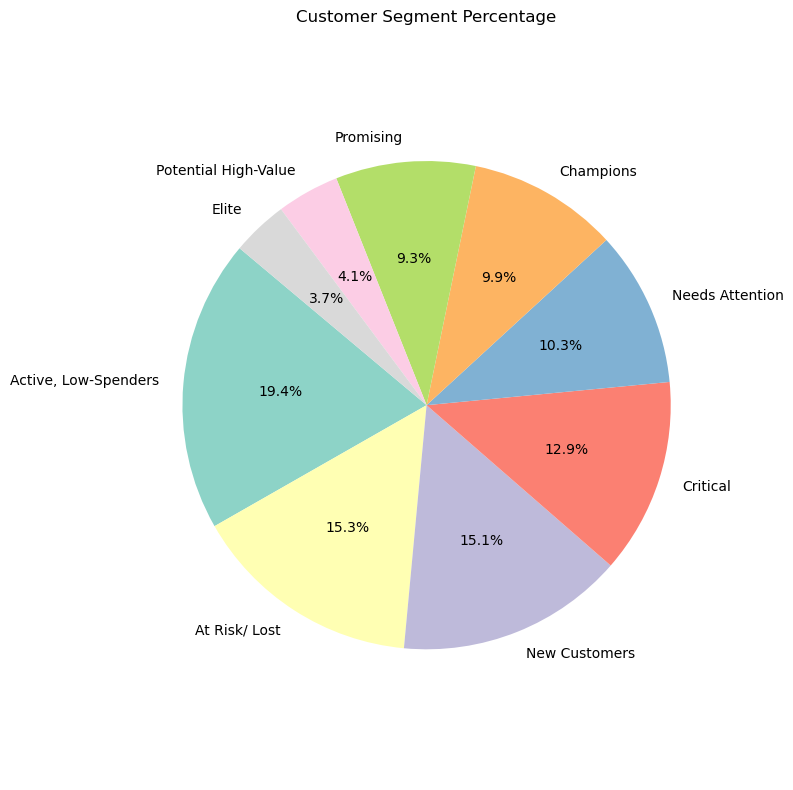

In [13]:
segment_counts = rfm['Segment_Final'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, 
        labels=segment_counts.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=plt.cm.Set3.colors)

plt.title('Customer Segment Percentage')
plt.axis('equal') 
plt.tight_layout()
plt.show()

## 1.2 Fraud Risk Analysis
    
    Since our dataset is unlabeled (due to absence of historical data that gives a Fraud dimension to the dataset), we cannot use supervised learning models like Logicstic Regression or XGBoost (which is much superior). Instead, the viable algorithm of choice here is Isolation Forest for Anomlay Detection.

In [16]:
# Preparing data for Feature Selection
# Due to there being over 5000 unique locations, one-hot encoding for all such locations is not scalable. We will engineer
# a new feature out of this for each location, a Z-score, that will help detect anomalous transactions by comparing with the SD
# for said location.

import numpy as np
location_avg = tempdf.groupby('CustLocation')['TransactionAmount (INR)'].transform('mean')
location_std = tempdf.groupby('CustLocation')['TransactionAmount (INR)'].transform('std')

In [17]:
# Creating new features
tempdf['AmountZScoreByLocation'] = (tempdf['TransactionAmount (INR)'] - location_avg) / location_std
tempdf['AmountZScoreByLocation'].fillna(0, inplace=True)  ## Handling edge case of locations with only one transaction

/var/folders/8g/00b3gbs92n16plbgtl71gh8h0000gn/T/ipykernel_58011/929555483.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tempdf['AmountZScoreByLocation'].fillna(0, inplace=True)  ## Handling edge case of locations with only one transaction


In [20]:
tempdf['DayOfWeek'] = tempdf['TransactionDate'].dt.day_name()
tempdf['IsWeekend'] = tempdf['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)
holiday_list = ['2016-08-07', '2016-08-15', '2016-08-18', '2016-08-25', '2016-09-05', '2016-09-13',]
holiday_set = set(pd.to_datetime(holiday_list).date)

tempdf['IsHoliday'] = tempdf['TransactionDate'].dt.date.isin(holiday_set).astype(int)


print(tempdf[['TransactionDate', 'DayOfWeek', 'IsWeekend', 'IsHoliday']].head())
print("\nValue counts for new features:")
print(tempdf['IsWeekend'].value_counts(), '\n',tempdf['IsHoliday'].value_counts())

  TransactionDate DayOfWeek  IsWeekend  IsHoliday
0      2016-08-02   Tuesday          0          0
1      2016-08-02   Tuesday          0          0
2      2016-08-02   Tuesday          0          0
3      2016-08-02   Tuesday          0          0
4      2016-08-02   Tuesday          0          0

Value counts for new features:
IsWeekend
0    680977
1    303270
Name: count, dtype: int64 
 IsHoliday
0    860335
1    123912
Name: count, dtype: int64


In [21]:
from datetime import time

def get_time_of_day(t):
    if time(5, 0) <= t <= time(11, 59, 59):
        return 'Morning'
    elif time(12, 0) <= t <= time(16, 30, 59):
        return 'Afternoon'
    elif time(16, 31) <= t <= time(21, 30, 59):
        return 'Evening'
    elif time(21, 31) <= t <= time(23, 59, 59):
        return 'Night'
    else:
        return 'Late Night'

tempdf['TimeOfDay'] = tempdf['TransactionTime'].apply(get_time_of_day)
# Creating an 'IsLateNight' feature
# A lot of suspicious transactions and payment around illegal activities occur at late night
tempdf['IsLateNight'] = tempdf['TimeOfDay'].isin(['Late Night']).astype(int)

In [22]:
tempdf = tempdf.sort_values(by=['CustomerID', 'TransactionDate'])
tempdf = tempdf.reset_index(drop=True)

# Creating 'TimeSinceLastTxn'
previous_txn_time = tempdf.groupby('CustomerID')['TransactionDate'].shift()
tempdf['TimeSinceLastTxn'] = (tempdf['TransactionDate'] - previous_txn_time).dt.total_seconds()
tempdf['TimeSinceLastTxn'] = tempdf['TimeSinceLastTxn'].fillna(9999999) # handling edge case

# Creating 'TxnCountInLast24Hours'
# Rolling window to count transactions in the last 24 hours per customer
txn_count_series = tempdf.groupby('CustomerID').rolling('24h', on='TransactionDate')['TransactionDate'].count()

tempdf['TxnCountInLast24Hours'] = txn_count_series.values

print("\nVerifying for single customer:")
sample_customer_id = tempdf['CustomerID'].iloc[0] # ID of the first customer
print(tempdf[tempdf['CustomerID'] == sample_customer_id][['CustomerID', 'TransactionDate', 'TimeSinceLastTxn', 'TxnCountInLast24Hours']].head(10))


Verifying for single customer:
  CustomerID TransactionDate  TimeSinceLastTxn  TxnCountInLast24Hours
0   C1010011      2016-08-09         9999999.0                    1.0
1   C1010011      2016-09-26         4147200.0                    1.0


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Feature Selection
features = ['CustAccountBalance', 'TransactionAmount (INR)',
            'Age', 'AmountZScoreByLocation', 'IsWeekend', 'IsHoliday',
            'TimeSinceLastTxn', 'TxnCountInLast24Hours', 'IsLateNight']

X = tempdf[features]

# Handling edge case of values being inf or too large to fit in X
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

# To avoid bias towards columns with larger values like TransactionAmt
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso_forest = IsolationForest(contamination=0.01, random_state=42)

predictions = iso_forest.fit_predict(X_scaled) # Returns -1 for anomalies and 1 for normal data

tempdf['IsAnomaly'] = predictions
print("Anomaly detection results:")
print(tempdf['IsAnomaly'].value_counts())

print("\nSample df with transactions flagged as anomalies (-1):")
tempdf[tempdf['IsAnomaly'] == -1].head()

/var/folders/8g/00b3gbs92n16plbgtl71gh8h0000gn/T/ipykernel_58011/18963679.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/8g/00b3gbs92n16plbgtl71gh8h0000gn/T/ipykernel_58011/18963679.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Anomaly detection results:
IsAnomaly
 1    974404
-1      9843
Name: count, dtype: int64

Sample df with transactions flagged as anomalies (-1):


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,age_group,AmountZScoreByLocation,DayOfWeek,IsWeekend,IsHoliday,TimeOfDay,IsLateNight,TimeSinceLastTxn,TxnCountInLast24Hours,IsAnomaly
18,T957663,C1010041,1993-09-06,F,DELHI,34119.48,2016-09-10,16:25:33,14500.00,23,20–25,2.524663,Saturday,1,0,Afternoon,0,259200.0,1.0,-1
21,T588034,C1010046,1985-01-30,M,NEW DELHI,2851080.38,2016-08-27,19:56:00,156658.74,31,26–35,20.192597,Saturday,1,0,Evening,0,1123200.0,1.0,-1
186,T792121,C1010621,1940-12-24,M,GUWAHATI,4251160.55,2016-09-05,10:59:35,22056.00,75,60+,3.873645,Monday,0,1,Morning,0,9999999.0,1.0,-1
242,T789608,C1010757,1990-12-03,M,MUMBAI,2198.72,2016-09-05,02:08:54,3200.00,25,20–25,0.236949,Monday,0,1,Late Night,1,604800.0,1.0,-1
357,T1045875,C1011140,1975-06-04,M,MUMBAI,15158474.07,2016-09-18,13:05:45,1591.00,41,36–45,-0.004632,Sunday,1,0,Afternoon,0,1296000.0,1.0,-1


In [24]:
fraud_df = tempdf[tempdf['IsAnomaly'] == -1]
print("Statistical profile of the flagged anomalies:\n\n", fraud_df[features].describe())

Statistical profile of the flagged anomalies:

        CustAccountBalance  TransactionAmount (INR)          Age  \
count        9.843000e+03             9.843000e+03  9843.000000   
mean         1.487213e+06             3.251652e+04    40.683328   
std          5.930282e+06             4.625299e+04    14.454484   
min          0.000000e+00             0.000000e+00    11.000000   
25%          3.344690e+04             8.880465e+03    29.000000   
50%          1.766582e+05             2.346345e+04    38.000000   
75%          9.469636e+05             4.146900e+04    49.000000   
max          1.150355e+08             1.560035e+06   106.000000   

       AmountZScoreByLocation    IsWeekend    IsHoliday  TimeSinceLastTxn  \
count             9843.000000  9843.000000  9843.000000      9.843000e+03   
mean                 5.342986     0.428934     0.325003      7.032083e+06   
std                  6.859707     0.494949     0.468400      4.229287e+06   
min                 -1.219045     0.0000

In [25]:
fraud_df['RiskScore'] = 0
fraud_df['RiskScore'] += fraud_df['AmountZScoreByLocation'].clip(lower=0) #Ignoring negative Zscores

fraud_df.loc[fraud_df['TimeSinceLastTxn'] < 300, 'RiskScore'] += 10
fraud_df.loc[fraud_df['TxnCountInLast24Hours'] > 1, 'RiskScore'] += 5

fraud_df.loc[fraud_df['IsLateNight'] == 1, 'RiskScore'] += 5
fraud_df.loc[fraud_df['IsWeekend'] == 1, 'RiskScore'] += 3
fraud_df.loc[fraud_df['IsHoliday'] == 1, 'RiskScore'] += 3

# Segment Definition:
# 1. Critical: Top 5% of scores
# 2. High Priority: 80% - 95% of scores
# 3. Medium Priority: 50% - 80% of scores
# 4. Monitor: Bottom 50% of scores
quantiles = fraud_df['RiskScore'].quantile([0, 0.5, 0.8, 0.95, 1.0])
labels = ['Monitor', 'Medium Priority', 'High Priority', 'Critical']
fraud_df['Segment'] = pd.cut(fraud_df['RiskScore'], bins=quantiles, labels=labels, include_lowest=True)

print("Transactions across the fraudulent segments:")
print(fraud_df['Segment'].value_counts())

print("\nStatistical Profile of Each New Segment")
print(fraud_df.groupby('Segment')[['RiskScore', 'AmountZScoreByLocation', 'TimeSinceLastTxn']].mean())

Transactions across the fraudulent segments:
Segment
Monitor            4922
Medium Priority    2952
High Priority      1476
Critical            493
Name: count, dtype: int64

Statistical Profile of Each New Segment
                 RiskScore  AmountZScoreByLocation  TimeSinceLastTxn
Segment                                                             
Monitor           5.166157                2.878030      6.391329e+06
Medium Priority   9.260199                4.961927      7.880224e+06
High Priority    14.006403                9.749510      7.899759e+06
Critical         27.088625               19.041506      5.752950e+06


/var/folders/8g/00b3gbs92n16plbgtl71gh8h0000gn/T/ipykernel_58011/3998935246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['RiskScore'] = 0
/var/folders/8g/00b3gbs92n16plbgtl71gh8h0000gn/T/ipykernel_58011/3998935246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['RiskScore'] += fraud_df['AmountZScoreByLocation'].clip(lower=0) #Ignoring negative Zscores
/var/folders/8g/00b3gbs92n16plbgtl71gh8h0000gn/T/ipykernel_58011/3998935246.py:18: SettingWithCopyWarning: 
A value is trying to 

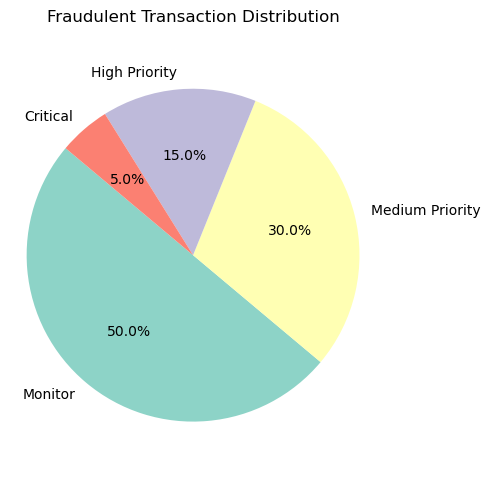

In [26]:
segments = fraud_df['Segment'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(segments, 
        labels=segments.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=plt.cm.Set3.colors)

plt.title('Fraudulent Transaction Distribution')
plt.axis('equal') 
plt.tight_layout()
plt.show()